In [1]:
# !rm -rf /kaggle/working/handwriting-generator-model
# !git clone https://github.com/Shambu-K/handwriting-generator-model.git
# !pip install fastdtw
# %cd /kaggle/working/handwriting-generator-model/Code/STR_model

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader
from model import STR_Model, STR_Model_Longer_512, STR_Model_Longer_1024
from dataset.iam_dataloader import HandwritingDataset
from loss.stroke_loss import STR_Loss_DTW, STR_Loss_Identity
from util.visualize_progress import visualize_progress, plot_losses
from fastdtw import fastdtw
from tqdm.notebook import tqdm
import os

In [3]:
def train(model, train_loader, loss_function, optimizer, device, epoch=0):
    # Setting the model to training mode
    model.train() 
    length = len(train_loader)
    # Looping over each batch from the training set 
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc=f'Epoch {epoch}', total=length, disable=True):  
        # data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  
        output = model(data)  
        loss, dtw_loss, sos_loss, eos_loss  = loss_function(output, target) 
        loss.backward()
        # Updating the model parameters
        optimizer.step() 

        if batch_idx % 100 == 0:
            print(f'   Batch: {batch_idx:<4} | Width: {data.shape[-1]:<3} | Loss: {loss.item():.4f}')
            
    return loss.item(), dtw_loss.item(), sos_loss.item(), eos_loss.item()

def model_fit(model, train_loader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint, plot=1):
    train_losses, dtw_losses, sos_losses, eos_losses = [], [], [], []
    for epoch in tqdm(range(num_epochs)):
        if epoch % plot == 0: 
            print('=====================================================================\n')
            if len(train_losses) > 0: print(f'Epoch: {epoch} | Loss: {train_losses[-1]}')
            visualize_progress(model, device, train_loader, epoch)
        loss, dtw_loss, sos_loss, eos_loss = train(model, train_loader, loss_function, optimizer, device, epoch+1)
        scheduler.step()

        train_losses.append(loss)
        dtw_losses.append(dtw_loss)
        sos_losses.append(sos_loss)
        eos_losses.append(eos_loss)

        if epoch % checkpoint == 0:
            model_file = f'./checkpoints/{model.__class__.__name__}_{epoch}_{int(loss)}.pth'
            torch.save(model.state_dict(), model_file) 
    
    return train_losses, dtw_losses, sos_losses, eos_losses

# Util functions
def set_best_model(model, checkpoint_dir):
    ''' Set the model with least loss as the best model. '''
    best_loss = 100000
    best_model = None
    for file in os.listdir(checkpoint_dir):
        if file.endswith('.pth') and file.startswith(model.__class__.__name__):
            loss = int(file.split('_')[-1].split('.')[0])
            if loss < best_loss:
                best_loss = loss
                best_model = file
    if best_model is not None:
        model.load_state_dict(torch.load(os.path.join(checkpoint_dir, best_model)))
        print(f'Best model: {best_model}')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Training parameters
num_epochs = 2000
batch_size = 16 # Archibald it is 32
checkpoint_interval = 100
learning_rate = 0.001
lr_decay = 1

print('Using device:', device)

Using device: cuda


In [5]:
# Load data
# root_dir = '/kaggle/input/iam-dataset-online/Resized_Dataset/Train'
root_dir = '../../DataSet/IAM-Online/Resized_Dataset/Train/'
dataset = HandwritingDataset(root_dir, batch_size, device, max_allowed_width=150)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

Preprocessing data: 100%|██████████| 1633/1633 [00:10<00:00, 162.66it/s]


In [6]:
# For singluar image
idx = 14000
dataloader = [(dataset[idx][0].unsqueeze(0), dataset[idx][1].unsqueeze(0))]

In [7]:
# Model
model = STR_Model_Longer_1024(relative_coords=False).to(device)
# set_best_model(model, './checkpoints/')
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)
loss_function = STR_Loss_Identity(sos_weight=20)

  0%|          | 0/2000 [00:00<?, ?it/s]

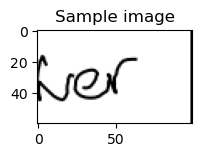

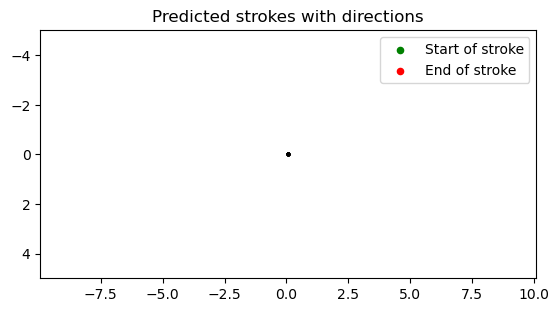

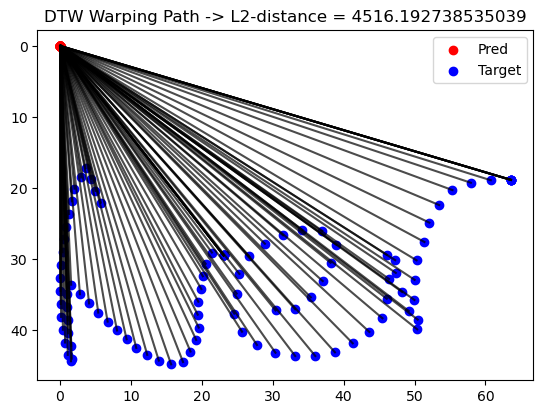

   Batch: 0    | Width: 100 | Loss: 31.7434
   Batch: 0    | Width: 100 | Loss: 31.2803
   Batch: 0    | Width: 100 | Loss: 30.6299
   Batch: 0    | Width: 100 | Loss: 30.1576
   Batch: 0    | Width: 100 | Loss: 29.6269
   Batch: 0    | Width: 100 | Loss: 29.1070
   Batch: 0    | Width: 100 | Loss: 28.6252
   Batch: 0    | Width: 100 | Loss: 28.1285
   Batch: 0    | Width: 100 | Loss: 27.6302
   Batch: 0    | Width: 100 | Loss: 27.1469
   Batch: 0    | Width: 100 | Loss: 26.6636
   Batch: 0    | Width: 100 | Loss: 26.2589
   Batch: 0    | Width: 100 | Loss: 25.8504
   Batch: 0    | Width: 100 | Loss: 25.4413
   Batch: 0    | Width: 100 | Loss: 25.1049
   Batch: 0    | Width: 100 | Loss: 24.8156
   Batch: 0    | Width: 100 | Loss: 24.4599
   Batch: 0    | Width: 100 | Loss: 24.1542
   Batch: 0    | Width: 100 | Loss: 23.9118
   Batch: 0    | Width: 100 | Loss: 23.5531
   Batch: 0    | Width: 100 | Loss: 23.2599
   Batch: 0    | Width: 100 | Loss: 22.9607
   Batch: 0    | Width: 100 | Lo

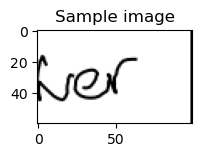

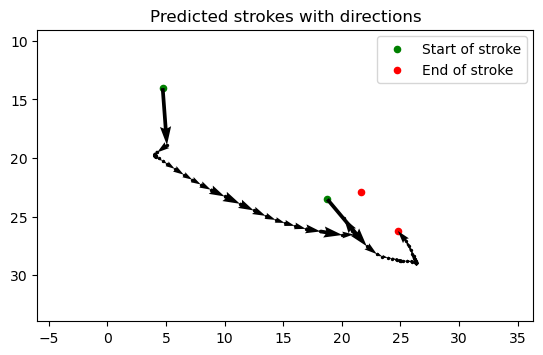

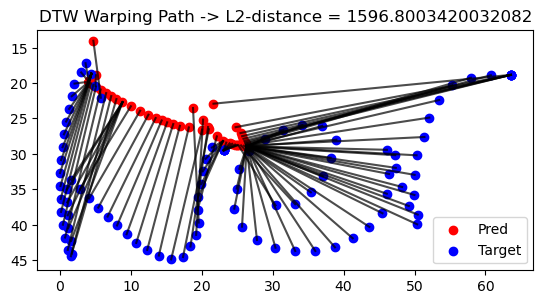

   Batch: 0    | Width: 100 | Loss: 9.7429
   Batch: 0    | Width: 100 | Loss: 9.7122
   Batch: 0    | Width: 100 | Loss: 9.5999
   Batch: 0    | Width: 100 | Loss: 9.5144
   Batch: 0    | Width: 100 | Loss: 9.4589
   Batch: 0    | Width: 100 | Loss: 9.3974
   Batch: 0    | Width: 100 | Loss: 9.2992
   Batch: 0    | Width: 100 | Loss: 9.2465
   Batch: 0    | Width: 100 | Loss: 9.1902
   Batch: 0    | Width: 100 | Loss: 9.0763
   Batch: 0    | Width: 100 | Loss: 9.0237
   Batch: 0    | Width: 100 | Loss: 8.9451
   Batch: 0    | Width: 100 | Loss: 8.9442
   Batch: 0    | Width: 100 | Loss: 8.8823
   Batch: 0    | Width: 100 | Loss: 8.8024
   Batch: 0    | Width: 100 | Loss: 8.7156
   Batch: 0    | Width: 100 | Loss: 8.6859
   Batch: 0    | Width: 100 | Loss: 8.6207
   Batch: 0    | Width: 100 | Loss: 8.5891
   Batch: 0    | Width: 100 | Loss: 8.5027
   Batch: 0    | Width: 100 | Loss: 8.5255
   Batch: 0    | Width: 100 | Loss: 8.4141
   Batch: 0    | Width: 100 | Loss: 8.3749
   Batch: 0

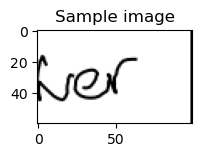

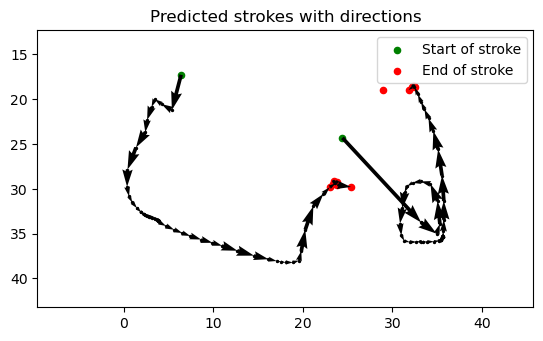

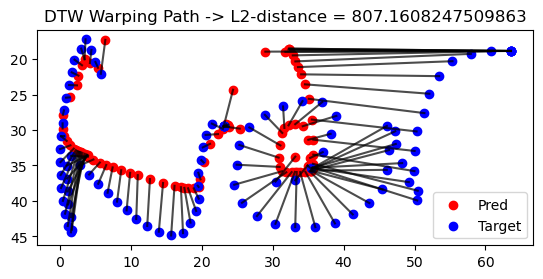

   Batch: 0    | Width: 100 | Loss: 4.6696
   Batch: 0    | Width: 100 | Loss: 4.9130
   Batch: 0    | Width: 100 | Loss: 4.5880
   Batch: 0    | Width: 100 | Loss: 4.5743
   Batch: 0    | Width: 100 | Loss: 4.5016
   Batch: 0    | Width: 100 | Loss: 4.4072
   Batch: 0    | Width: 100 | Loss: 4.3650
   Batch: 0    | Width: 100 | Loss: 4.3083
   Batch: 0    | Width: 100 | Loss: 4.2427
   Batch: 0    | Width: 100 | Loss: 4.1877
   Batch: 0    | Width: 100 | Loss: 4.1773
   Batch: 0    | Width: 100 | Loss: 4.0943
   Batch: 0    | Width: 100 | Loss: 4.0723
   Batch: 0    | Width: 100 | Loss: 4.0056
   Batch: 0    | Width: 100 | Loss: 3.9617
   Batch: 0    | Width: 100 | Loss: 3.8695
   Batch: 0    | Width: 100 | Loss: 3.9316
   Batch: 0    | Width: 100 | Loss: 3.7580
   Batch: 0    | Width: 100 | Loss: 3.8105
   Batch: 0    | Width: 100 | Loss: 3.7418
   Batch: 0    | Width: 100 | Loss: 3.7074
   Batch: 0    | Width: 100 | Loss: 3.7121
   Batch: 0    | Width: 100 | Loss: 3.7060
   Batch: 0

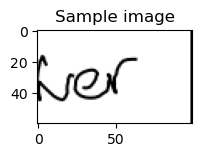

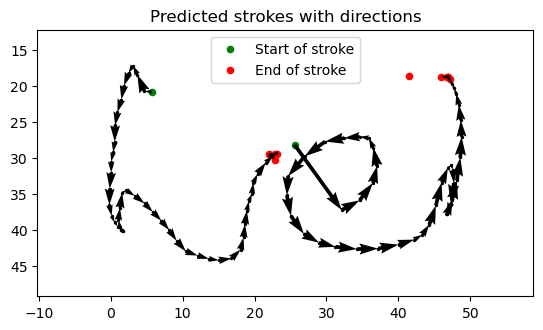

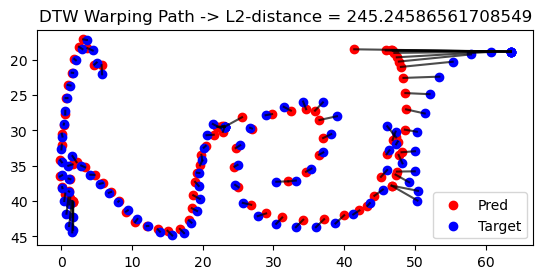

   Batch: 0    | Width: 100 | Loss: 1.6229
   Batch: 0    | Width: 100 | Loss: 1.5469
   Batch: 0    | Width: 100 | Loss: 1.4975
   Batch: 0    | Width: 100 | Loss: 1.5151
   Batch: 0    | Width: 100 | Loss: 1.5173
   Batch: 0    | Width: 100 | Loss: 1.5575
   Batch: 0    | Width: 100 | Loss: 1.4335
   Batch: 0    | Width: 100 | Loss: 1.5403
   Batch: 0    | Width: 100 | Loss: 1.4969
   Batch: 0    | Width: 100 | Loss: 1.5578
   Batch: 0    | Width: 100 | Loss: 1.5876
   Batch: 0    | Width: 100 | Loss: 1.5211
   Batch: 0    | Width: 100 | Loss: 1.5567
   Batch: 0    | Width: 100 | Loss: 1.5733
   Batch: 0    | Width: 100 | Loss: 1.6653
   Batch: 0    | Width: 100 | Loss: 1.4571
   Batch: 0    | Width: 100 | Loss: 1.4123
   Batch: 0    | Width: 100 | Loss: 1.4034
   Batch: 0    | Width: 100 | Loss: 1.5052
   Batch: 0    | Width: 100 | Loss: 1.4851
   Batch: 0    | Width: 100 | Loss: 1.4526
   Batch: 0    | Width: 100 | Loss: 1.3575
   Batch: 0    | Width: 100 | Loss: 1.3390
   Batch: 0

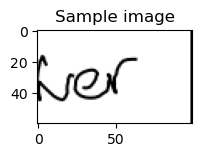

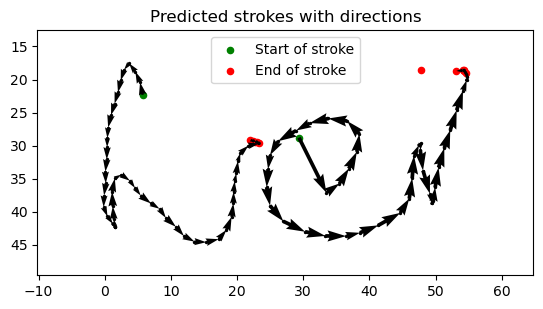

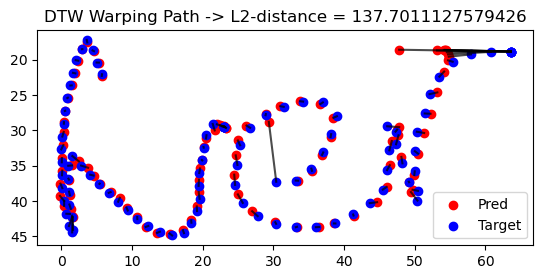

   Batch: 0    | Width: 100 | Loss: 0.9049
   Batch: 0    | Width: 100 | Loss: 0.8503
   Batch: 0    | Width: 100 | Loss: 0.8626
   Batch: 0    | Width: 100 | Loss: 0.9117
   Batch: 0    | Width: 100 | Loss: 0.9948
   Batch: 0    | Width: 100 | Loss: 0.9467
   Batch: 0    | Width: 100 | Loss: 0.9206
   Batch: 0    | Width: 100 | Loss: 0.9076
   Batch: 0    | Width: 100 | Loss: 0.8795
   Batch: 0    | Width: 100 | Loss: 0.9081
   Batch: 0    | Width: 100 | Loss: 0.9392
   Batch: 0    | Width: 100 | Loss: 0.9422
   Batch: 0    | Width: 100 | Loss: 0.9241
   Batch: 0    | Width: 100 | Loss: 0.9114
   Batch: 0    | Width: 100 | Loss: 0.8775
   Batch: 0    | Width: 100 | Loss: 0.8738
   Batch: 0    | Width: 100 | Loss: 0.9253
   Batch: 0    | Width: 100 | Loss: 0.8364
   Batch: 0    | Width: 100 | Loss: 0.8180
   Batch: 0    | Width: 100 | Loss: 0.8913
   Batch: 0    | Width: 100 | Loss: 0.8458
   Batch: 0    | Width: 100 | Loss: 0.8550
   Batch: 0    | Width: 100 | Loss: 0.8391
   Batch: 0

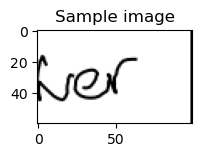

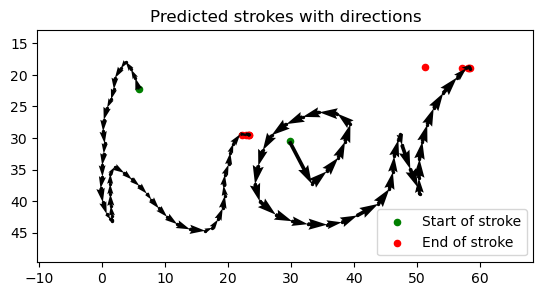

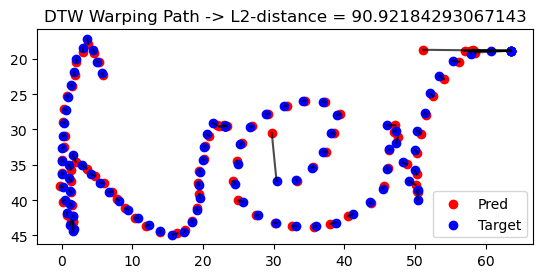

   Batch: 0    | Width: 100 | Loss: 0.6809
   Batch: 0    | Width: 100 | Loss: 0.6914
   Batch: 0    | Width: 100 | Loss: 0.6394
   Batch: 0    | Width: 100 | Loss: 0.6586
   Batch: 0    | Width: 100 | Loss: 0.6316
   Batch: 0    | Width: 100 | Loss: 0.6155
   Batch: 0    | Width: 100 | Loss: 0.5995
   Batch: 0    | Width: 100 | Loss: 0.6609
   Batch: 0    | Width: 100 | Loss: 0.6303
   Batch: 0    | Width: 100 | Loss: 0.6428
   Batch: 0    | Width: 100 | Loss: 0.6666
   Batch: 0    | Width: 100 | Loss: 0.6531
   Batch: 0    | Width: 100 | Loss: 0.7204
   Batch: 0    | Width: 100 | Loss: 0.6276
   Batch: 0    | Width: 100 | Loss: 0.6262
   Batch: 0    | Width: 100 | Loss: 0.6577
   Batch: 0    | Width: 100 | Loss: 0.6899
   Batch: 0    | Width: 100 | Loss: 0.6217
   Batch: 0    | Width: 100 | Loss: 0.6764
   Batch: 0    | Width: 100 | Loss: 0.7031
   Batch: 0    | Width: 100 | Loss: 0.6124
   Batch: 0    | Width: 100 | Loss: 0.6444
   Batch: 0    | Width: 100 | Loss: 0.6320
   Batch: 0

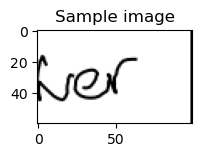

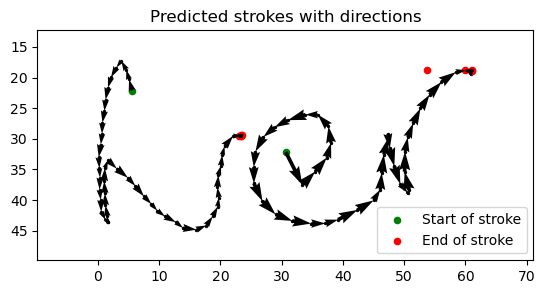

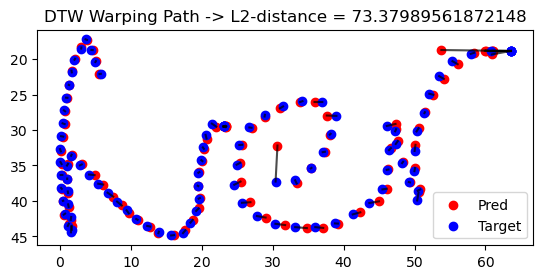

   Batch: 0    | Width: 100 | Loss: 0.5279
   Batch: 0    | Width: 100 | Loss: 0.5671
   Batch: 0    | Width: 100 | Loss: 0.5162
   Batch: 0    | Width: 100 | Loss: 0.4750
   Batch: 0    | Width: 100 | Loss: 0.4970
   Batch: 0    | Width: 100 | Loss: 0.4997
   Batch: 0    | Width: 100 | Loss: 0.4841
   Batch: 0    | Width: 100 | Loss: 0.5437
   Batch: 0    | Width: 100 | Loss: 0.5021
   Batch: 0    | Width: 100 | Loss: 0.5097
   Batch: 0    | Width: 100 | Loss: 0.5028
   Batch: 0    | Width: 100 | Loss: 0.5075
   Batch: 0    | Width: 100 | Loss: 0.4642
   Batch: 0    | Width: 100 | Loss: 0.4757
   Batch: 0    | Width: 100 | Loss: 0.4568
   Batch: 0    | Width: 100 | Loss: 0.4883
   Batch: 0    | Width: 100 | Loss: 0.5140
   Batch: 0    | Width: 100 | Loss: 0.5043
   Batch: 0    | Width: 100 | Loss: 0.4388
   Batch: 0    | Width: 100 | Loss: 0.5103
   Batch: 0    | Width: 100 | Loss: 0.4441
   Batch: 0    | Width: 100 | Loss: 0.4677
   Batch: 0    | Width: 100 | Loss: 0.4626
   Batch: 0

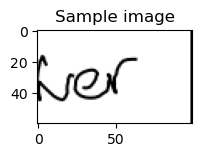

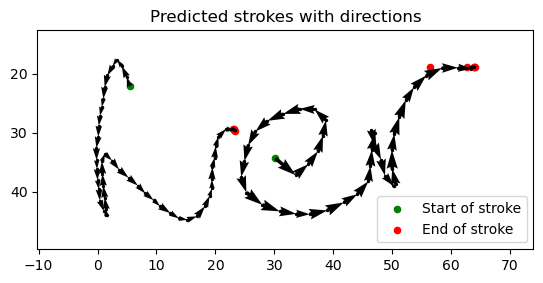

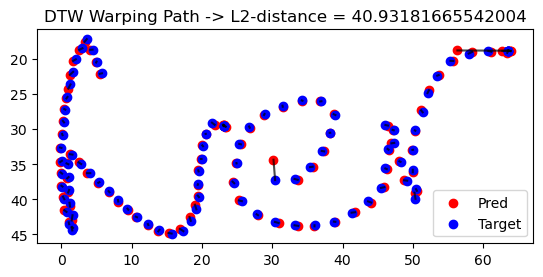

   Batch: 0    | Width: 100 | Loss: 0.3704
   Batch: 0    | Width: 100 | Loss: 0.3503
   Batch: 0    | Width: 100 | Loss: 0.3482
   Batch: 0    | Width: 100 | Loss: 0.3857
   Batch: 0    | Width: 100 | Loss: 0.3582
   Batch: 0    | Width: 100 | Loss: 0.3358
   Batch: 0    | Width: 100 | Loss: 0.3651
   Batch: 0    | Width: 100 | Loss: 0.3942
   Batch: 0    | Width: 100 | Loss: 0.4043
   Batch: 0    | Width: 100 | Loss: 0.4442
   Batch: 0    | Width: 100 | Loss: 0.3838
   Batch: 0    | Width: 100 | Loss: 0.3964
   Batch: 0    | Width: 100 | Loss: 0.3596
   Batch: 0    | Width: 100 | Loss: 0.3939
   Batch: 0    | Width: 100 | Loss: 0.3961
   Batch: 0    | Width: 100 | Loss: 0.3884
   Batch: 0    | Width: 100 | Loss: 0.3666
   Batch: 0    | Width: 100 | Loss: 0.3920
   Batch: 0    | Width: 100 | Loss: 0.3997
   Batch: 0    | Width: 100 | Loss: 0.4290
   Batch: 0    | Width: 100 | Loss: 0.3590
   Batch: 0    | Width: 100 | Loss: 0.3617
   Batch: 0    | Width: 100 | Loss: 0.3835
   Batch: 0

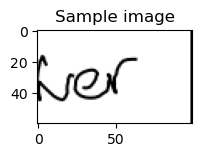

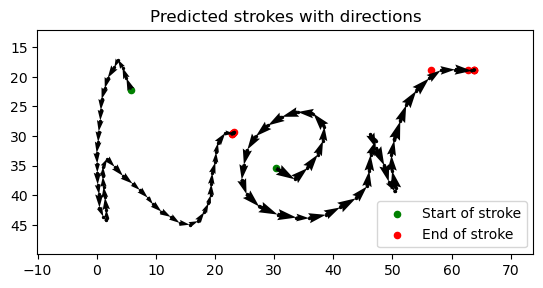

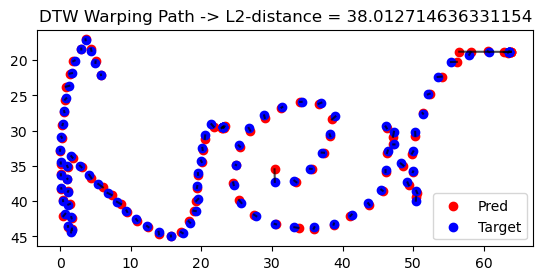

   Batch: 0    | Width: 100 | Loss: 0.3255
   Batch: 0    | Width: 100 | Loss: 0.3164
   Batch: 0    | Width: 100 | Loss: 0.2973
   Batch: 0    | Width: 100 | Loss: 0.3067
   Batch: 0    | Width: 100 | Loss: 0.3390
   Batch: 0    | Width: 100 | Loss: 0.3181
   Batch: 0    | Width: 100 | Loss: 0.2974
   Batch: 0    | Width: 100 | Loss: 0.3196
   Batch: 0    | Width: 100 | Loss: 0.2917
   Batch: 0    | Width: 100 | Loss: 0.3596
   Batch: 0    | Width: 100 | Loss: 0.3400
   Batch: 0    | Width: 100 | Loss: 0.4099
   Batch: 0    | Width: 100 | Loss: 0.3167
   Batch: 0    | Width: 100 | Loss: 0.3177
   Batch: 0    | Width: 100 | Loss: 0.3015
   Batch: 0    | Width: 100 | Loss: 0.3283
   Batch: 0    | Width: 100 | Loss: 0.2909
   Batch: 0    | Width: 100 | Loss: 0.2988
   Batch: 0    | Width: 100 | Loss: 0.3012
   Batch: 0    | Width: 100 | Loss: 0.3079
   Batch: 0    | Width: 100 | Loss: 0.3383
   Batch: 0    | Width: 100 | Loss: 0.2841
   Batch: 0    | Width: 100 | Loss: 0.3137
   Batch: 0

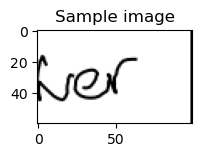

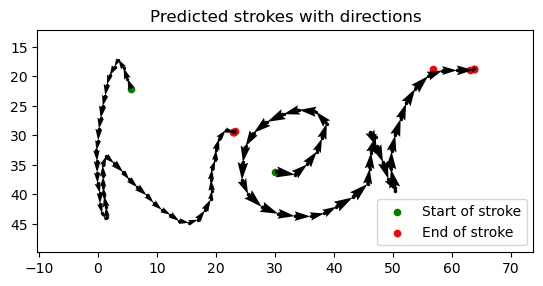

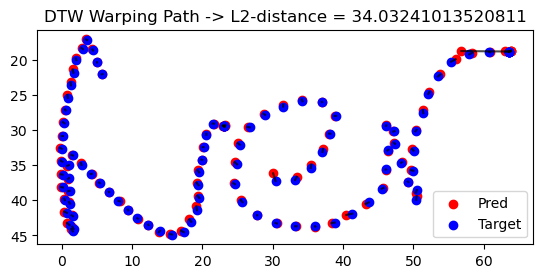

   Batch: 0    | Width: 100 | Loss: 0.3202
   Batch: 0    | Width: 100 | Loss: 0.3059
   Batch: 0    | Width: 100 | Loss: 0.2969
   Batch: 0    | Width: 100 | Loss: 0.2961
   Batch: 0    | Width: 100 | Loss: 0.2842
   Batch: 0    | Width: 100 | Loss: 0.2649
   Batch: 0    | Width: 100 | Loss: 0.2797
   Batch: 0    | Width: 100 | Loss: 0.2547
   Batch: 0    | Width: 100 | Loss: 0.2818
   Batch: 0    | Width: 100 | Loss: 0.3062
   Batch: 0    | Width: 100 | Loss: 0.3062
   Batch: 0    | Width: 100 | Loss: 0.2789
   Batch: 0    | Width: 100 | Loss: 0.2670
   Batch: 0    | Width: 100 | Loss: 0.2693
   Batch: 0    | Width: 100 | Loss: 0.3015
   Batch: 0    | Width: 100 | Loss: 0.2869
   Batch: 0    | Width: 100 | Loss: 0.2901
   Batch: 0    | Width: 100 | Loss: 0.2902
   Batch: 0    | Width: 100 | Loss: 0.2945
   Batch: 0    | Width: 100 | Loss: 0.3073
   Batch: 0    | Width: 100 | Loss: 0.3150
   Batch: 0    | Width: 100 | Loss: 0.2695
   Batch: 0    | Width: 100 | Loss: 0.3039
   Batch: 0

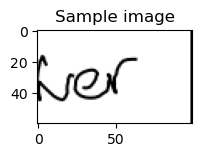

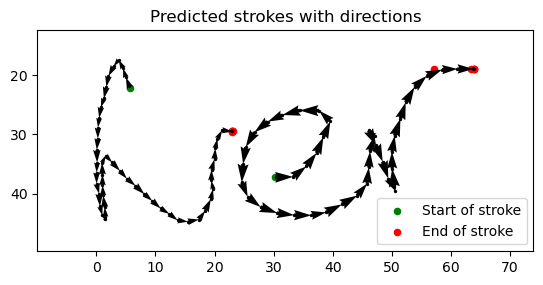

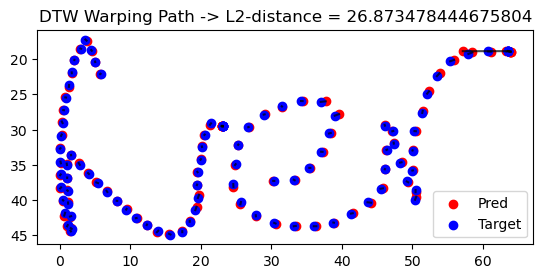

   Batch: 0    | Width: 100 | Loss: 0.2254
   Batch: 0    | Width: 100 | Loss: 0.2787
   Batch: 0    | Width: 100 | Loss: 0.2494
   Batch: 0    | Width: 100 | Loss: 0.2467
   Batch: 0    | Width: 100 | Loss: 0.2595
   Batch: 0    | Width: 100 | Loss: 0.2432
   Batch: 0    | Width: 100 | Loss: 0.2305
   Batch: 0    | Width: 100 | Loss: 0.2369
   Batch: 0    | Width: 100 | Loss: 0.2732
   Batch: 0    | Width: 100 | Loss: 0.2712
   Batch: 0    | Width: 100 | Loss: 0.2954
   Batch: 0    | Width: 100 | Loss: 0.2168
   Batch: 0    | Width: 100 | Loss: 0.2470
   Batch: 0    | Width: 100 | Loss: 0.2522
   Batch: 0    | Width: 100 | Loss: 0.2604
   Batch: 0    | Width: 100 | Loss: 0.2266
   Batch: 0    | Width: 100 | Loss: 0.2878
   Batch: 0    | Width: 100 | Loss: 0.2543
   Batch: 0    | Width: 100 | Loss: 0.2501
   Batch: 0    | Width: 100 | Loss: 0.2467
   Batch: 0    | Width: 100 | Loss: 0.3057
   Batch: 0    | Width: 100 | Loss: 0.2661
   Batch: 0    | Width: 100 | Loss: 0.2600
   Batch: 0

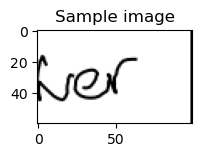

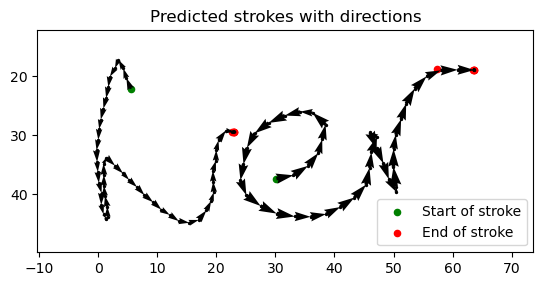

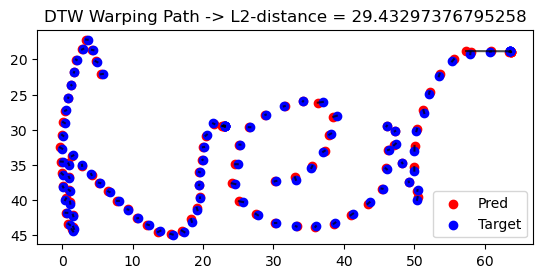

   Batch: 0    | Width: 100 | Loss: 0.2514
   Batch: 0    | Width: 100 | Loss: 0.2527
   Batch: 0    | Width: 100 | Loss: 0.2776
   Batch: 0    | Width: 100 | Loss: 0.2415
   Batch: 0    | Width: 100 | Loss: 0.2455
   Batch: 0    | Width: 100 | Loss: 0.2613
   Batch: 0    | Width: 100 | Loss: 0.2659
   Batch: 0    | Width: 100 | Loss: 0.2563
   Batch: 0    | Width: 100 | Loss: 0.2308
   Batch: 0    | Width: 100 | Loss: 0.2162
   Batch: 0    | Width: 100 | Loss: 0.2305
   Batch: 0    | Width: 100 | Loss: 0.2236
   Batch: 0    | Width: 100 | Loss: 0.2368
   Batch: 0    | Width: 100 | Loss: 0.2128
   Batch: 0    | Width: 100 | Loss: 0.2265
   Batch: 0    | Width: 100 | Loss: 0.2370
   Batch: 0    | Width: 100 | Loss: 0.2534
   Batch: 0    | Width: 100 | Loss: 0.2330
   Batch: 0    | Width: 100 | Loss: 0.2243
   Batch: 0    | Width: 100 | Loss: 0.2451
   Batch: 0    | Width: 100 | Loss: 0.2236
   Batch: 0    | Width: 100 | Loss: 0.2860
   Batch: 0    | Width: 100 | Loss: 0.2627
   Batch: 0

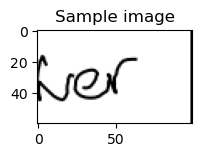

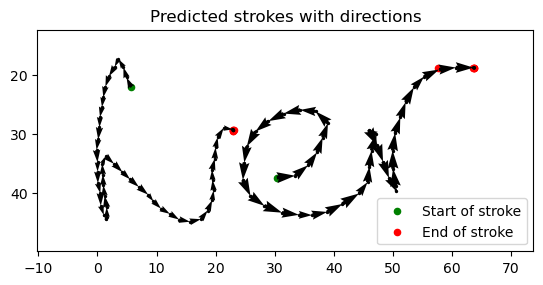

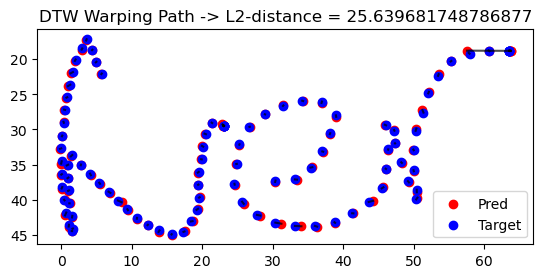

   Batch: 0    | Width: 100 | Loss: 0.2425
   Batch: 0    | Width: 100 | Loss: 0.2265
   Batch: 0    | Width: 100 | Loss: 0.2258
   Batch: 0    | Width: 100 | Loss: 0.2482
   Batch: 0    | Width: 100 | Loss: 0.2361
   Batch: 0    | Width: 100 | Loss: 0.2031
   Batch: 0    | Width: 100 | Loss: 0.2128
   Batch: 0    | Width: 100 | Loss: 0.2571
   Batch: 0    | Width: 100 | Loss: 0.2037
   Batch: 0    | Width: 100 | Loss: 0.2130
   Batch: 0    | Width: 100 | Loss: 0.2345
   Batch: 0    | Width: 100 | Loss: 0.2153
   Batch: 0    | Width: 100 | Loss: 0.2402
   Batch: 0    | Width: 100 | Loss: 0.2295
   Batch: 0    | Width: 100 | Loss: 0.2443
   Batch: 0    | Width: 100 | Loss: 0.2684
   Batch: 0    | Width: 100 | Loss: 0.2607
   Batch: 0    | Width: 100 | Loss: 0.2529
   Batch: 0    | Width: 100 | Loss: 0.2249
   Batch: 0    | Width: 100 | Loss: 0.2198
   Batch: 0    | Width: 100 | Loss: 0.2283
   Batch: 0    | Width: 100 | Loss: 0.2401
   Batch: 0    | Width: 100 | Loss: 0.2472
   Batch: 0

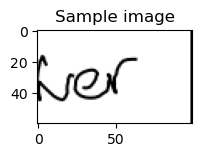

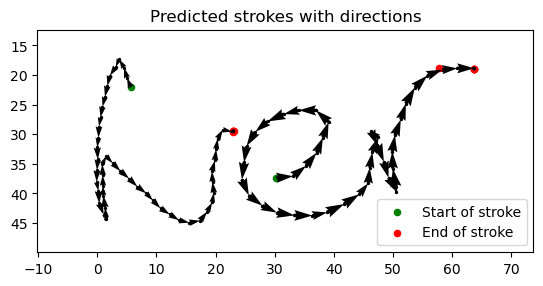

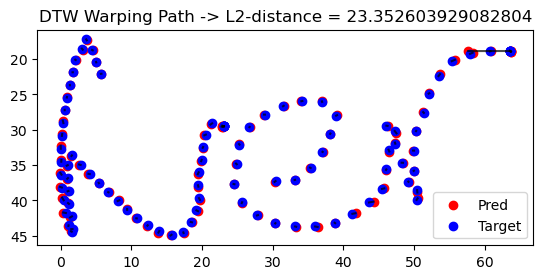

   Batch: 0    | Width: 100 | Loss: 0.1985
   Batch: 0    | Width: 100 | Loss: 0.2151
   Batch: 0    | Width: 100 | Loss: 0.2184
   Batch: 0    | Width: 100 | Loss: 0.2012
   Batch: 0    | Width: 100 | Loss: 0.2141
   Batch: 0    | Width: 100 | Loss: 0.2143
   Batch: 0    | Width: 100 | Loss: 0.2164
   Batch: 0    | Width: 100 | Loss: 0.1856
   Batch: 0    | Width: 100 | Loss: 0.2358
   Batch: 0    | Width: 100 | Loss: 0.2274
   Batch: 0    | Width: 100 | Loss: 0.2073
   Batch: 0    | Width: 100 | Loss: 0.1946
   Batch: 0    | Width: 100 | Loss: 0.1983
   Batch: 0    | Width: 100 | Loss: 0.2258
   Batch: 0    | Width: 100 | Loss: 0.2271
   Batch: 0    | Width: 100 | Loss: 0.2238
   Batch: 0    | Width: 100 | Loss: 0.2047
   Batch: 0    | Width: 100 | Loss: 0.2413
   Batch: 0    | Width: 100 | Loss: 0.1953
   Batch: 0    | Width: 100 | Loss: 0.1922
   Batch: 0    | Width: 100 | Loss: 0.2088
   Batch: 0    | Width: 100 | Loss: 0.2117
   Batch: 0    | Width: 100 | Loss: 0.1977
   Batch: 0

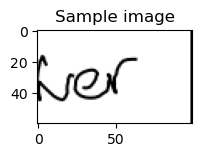

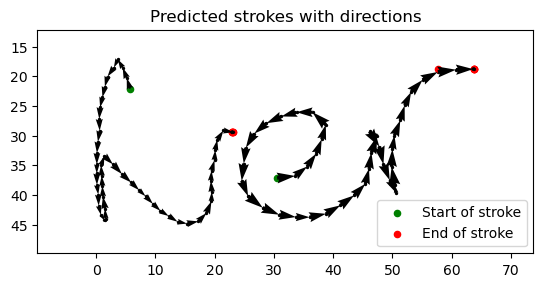

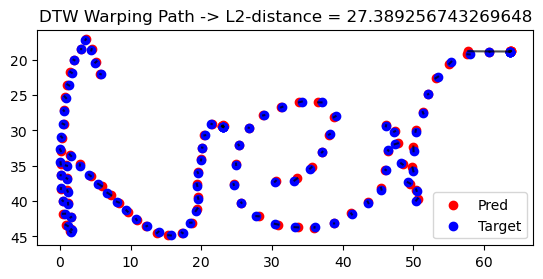

   Batch: 0    | Width: 100 | Loss: 0.2134
   Batch: 0    | Width: 100 | Loss: 0.1930
   Batch: 0    | Width: 100 | Loss: 0.2223
   Batch: 0    | Width: 100 | Loss: 0.2144
   Batch: 0    | Width: 100 | Loss: 0.1996
   Batch: 0    | Width: 100 | Loss: 0.1804
   Batch: 0    | Width: 100 | Loss: 0.1920
   Batch: 0    | Width: 100 | Loss: 0.1968
   Batch: 0    | Width: 100 | Loss: 0.1875
   Batch: 0    | Width: 100 | Loss: 0.1913
   Batch: 0    | Width: 100 | Loss: 0.2253
   Batch: 0    | Width: 100 | Loss: 0.1998
   Batch: 0    | Width: 100 | Loss: 0.2025
   Batch: 0    | Width: 100 | Loss: 0.1995
   Batch: 0    | Width: 100 | Loss: 0.1710
   Batch: 0    | Width: 100 | Loss: 0.2162
   Batch: 0    | Width: 100 | Loss: 0.2118
   Batch: 0    | Width: 100 | Loss: 0.1864
   Batch: 0    | Width: 100 | Loss: 0.1620
   Batch: 0    | Width: 100 | Loss: 0.1981
   Batch: 0    | Width: 100 | Loss: 0.2022
   Batch: 0    | Width: 100 | Loss: 0.1947
   Batch: 0    | Width: 100 | Loss: 0.1840
   Batch: 0

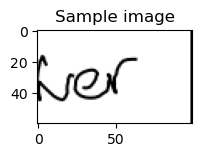

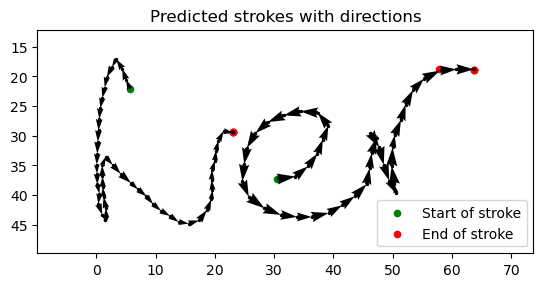

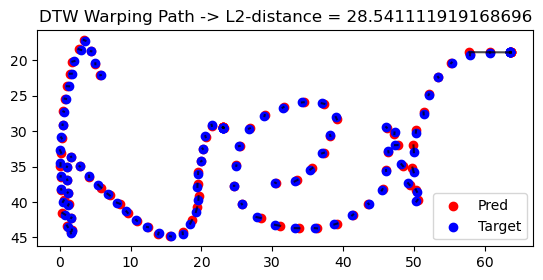

   Batch: 0    | Width: 100 | Loss: 0.1979
   Batch: 0    | Width: 100 | Loss: 0.1904
   Batch: 0    | Width: 100 | Loss: 0.1923
   Batch: 0    | Width: 100 | Loss: 0.1850
   Batch: 0    | Width: 100 | Loss: 0.2176
   Batch: 0    | Width: 100 | Loss: 0.2151
   Batch: 0    | Width: 100 | Loss: 0.1872
   Batch: 0    | Width: 100 | Loss: 0.1885
   Batch: 0    | Width: 100 | Loss: 0.1769
   Batch: 0    | Width: 100 | Loss: 0.1714
   Batch: 0    | Width: 100 | Loss: 0.1774
   Batch: 0    | Width: 100 | Loss: 0.1876
   Batch: 0    | Width: 100 | Loss: 0.1718
   Batch: 0    | Width: 100 | Loss: 0.1796
   Batch: 0    | Width: 100 | Loss: 0.1770
   Batch: 0    | Width: 100 | Loss: 0.1878
   Batch: 0    | Width: 100 | Loss: 0.2103
   Batch: 0    | Width: 100 | Loss: 0.2075
   Batch: 0    | Width: 100 | Loss: 0.1797
   Batch: 0    | Width: 100 | Loss: 0.1789
   Batch: 0    | Width: 100 | Loss: 0.1985
   Batch: 0    | Width: 100 | Loss: 0.1887
   Batch: 0    | Width: 100 | Loss: 0.1792
   Batch: 0

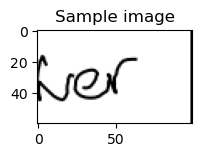

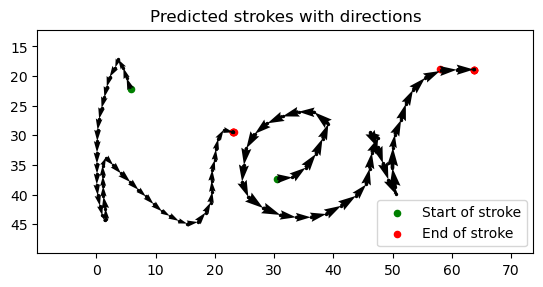

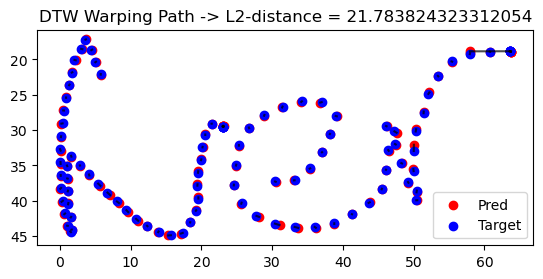

   Batch: 0    | Width: 100 | Loss: 0.1845
   Batch: 0    | Width: 100 | Loss: 0.1841
   Batch: 0    | Width: 100 | Loss: 0.1758
   Batch: 0    | Width: 100 | Loss: 0.1852
   Batch: 0    | Width: 100 | Loss: 0.1849
   Batch: 0    | Width: 100 | Loss: 0.1967
   Batch: 0    | Width: 100 | Loss: 0.1759
   Batch: 0    | Width: 100 | Loss: 0.1716
   Batch: 0    | Width: 100 | Loss: 0.1895
   Batch: 0    | Width: 100 | Loss: 0.1896
   Batch: 0    | Width: 100 | Loss: 0.1756
   Batch: 0    | Width: 100 | Loss: 0.1675
   Batch: 0    | Width: 100 | Loss: 0.1917
   Batch: 0    | Width: 100 | Loss: 0.1912
   Batch: 0    | Width: 100 | Loss: 0.1835
   Batch: 0    | Width: 100 | Loss: 0.1607
   Batch: 0    | Width: 100 | Loss: 0.1830
   Batch: 0    | Width: 100 | Loss: 0.1687
   Batch: 0    | Width: 100 | Loss: 0.1798
   Batch: 0    | Width: 100 | Loss: 0.1723
   Batch: 0    | Width: 100 | Loss: 0.1734
   Batch: 0    | Width: 100 | Loss: 0.1880
   Batch: 0    | Width: 100 | Loss: 0.2083
   Batch: 0

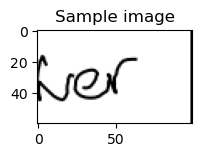

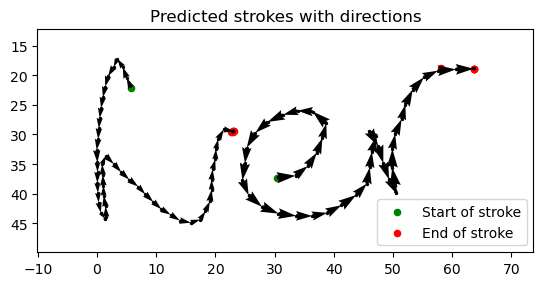

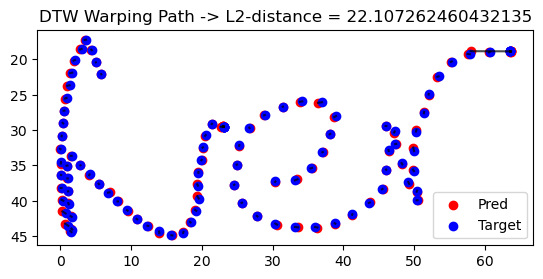

   Batch: 0    | Width: 100 | Loss: 0.1613
   Batch: 0    | Width: 100 | Loss: 0.1791
   Batch: 0    | Width: 100 | Loss: 0.1915
   Batch: 0    | Width: 100 | Loss: 0.1586
   Batch: 0    | Width: 100 | Loss: 0.1572
   Batch: 0    | Width: 100 | Loss: 0.1632
   Batch: 0    | Width: 100 | Loss: 0.1706
   Batch: 0    | Width: 100 | Loss: 0.1599
   Batch: 0    | Width: 100 | Loss: 0.1725
   Batch: 0    | Width: 100 | Loss: 0.1698
   Batch: 0    | Width: 100 | Loss: 0.1691
   Batch: 0    | Width: 100 | Loss: 0.1707
   Batch: 0    | Width: 100 | Loss: 0.1851
   Batch: 0    | Width: 100 | Loss: 0.1694
   Batch: 0    | Width: 100 | Loss: 0.1643
   Batch: 0    | Width: 100 | Loss: 0.1671
   Batch: 0    | Width: 100 | Loss: 0.1546
   Batch: 0    | Width: 100 | Loss: 0.1457
   Batch: 0    | Width: 100 | Loss: 0.1484
   Batch: 0    | Width: 100 | Loss: 0.1638
   Batch: 0    | Width: 100 | Loss: 0.1565
   Batch: 0    | Width: 100 | Loss: 0.1816
   Batch: 0    | Width: 100 | Loss: 0.1567
   Batch: 0

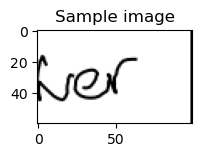

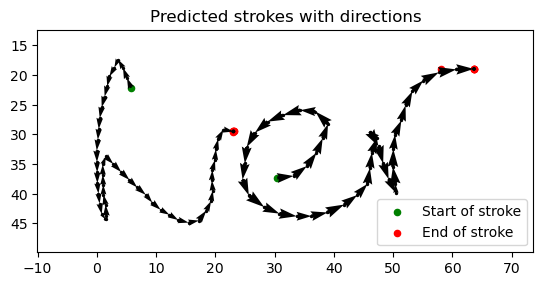

In [8]:
# Fitting the model
losses = model_fit(model, dataloader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint_interval, plot=100)

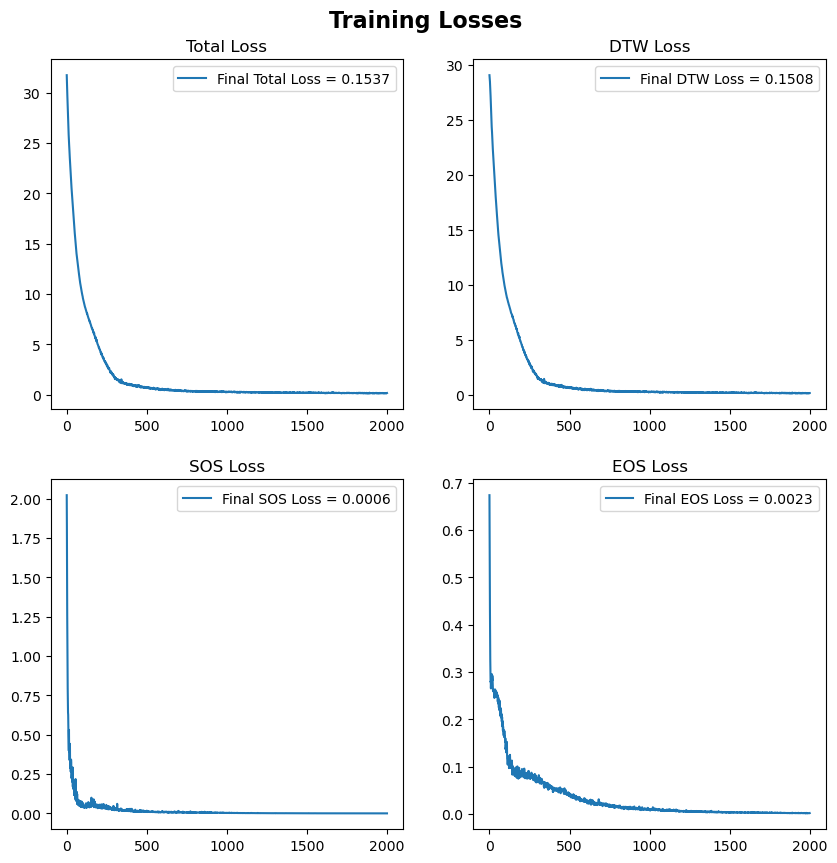

In [ ]:
plot_losses(losses)